In [1]:
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Data
from collections import defaultdict
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from torch_geometric.nn import GATConv
from torch.nn import Linear

In [2]:
classesDF  = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd-year\2nd-semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_classes.csv")

# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]

# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})

classesDF.head(5)

,txId,class
3,232438397,0
9,232029206,0
10,232344069,0
11,27553029,0
16,3881097,0


In [3]:
edgesDF = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd-year\2nd-semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_edgelist.csv")

edgesDF.head(5)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [4]:
featuresDF = pd.read_csv(r"C:\Users\User\Desktop\UAB\3rd-year\2nd-semester\synthesis project II\elliptic_bitcoin_dataset\elliptic_txs_features.csv", header=None)

# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]

# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]

featuresDF.head(5)

,txId,timestep,f0,f1,f2,f3,f4,f5,f6,f7,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [5]:
# Append the class to the featuresDF based on txID
featuresDF = featuresDF.merge(classesDF, on='txId')

# Move features 'class' to first column
cols = list(featuresDF.columns)
cols = cols[:1] + [cols[-1]] + cols[1:-1]
featuresDF = featuresDF[cols]

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [6]:
"""
connections_dict = {}



for _, row in edgesDF.iterrows():
    txId1, txId2 = row['txId1'], row['txId2']
    
    if txId1 not in connections_dict:
        connections_dict[txId1] = []
    if txId2 not in connections_dict:
        connections_dict[txId2] = []
        
    connections_dict[txId1].append(txId2)
    connections_dict[txId2].append(txId1)

# Función para obtener la lista de conexiones de un txId
def get_connections(txId):
    return connections_dict.get(txId, [])

# Aplicar la función a cada fila de featuresDF para crear la nueva columna 'edges'
featuresDF['edges'] = featuresDF['txId'].apply(get_connections)

featuresDF.head()"""

"\nconnections_dict = {}\n\n\n\nfor _, row in edgesDF.iterrows():\n    txId1, txId2 = row['txId1'], row['txId2']\n    \n    if txId1 not in connections_dict:\n        connections_dict[txId1] = []\n    if txId2 not in connections_dict:\n        connections_dict[txId2] = []\n        \n    connections_dict[txId1].append(txId2)\n    connections_dict[txId2].append(txId1)\n\n# Función para obtener la lista de conexiones de un txId\ndef get_connections(txId):\n    return connections_dict.get(txId, [])\n\n# Aplicar la función a cada fila de featuresDF para crear la nueva columna 'edges'\nfeaturesDF['edges'] = featuresDF['txId'].apply(get_connections)\n\nfeaturesDF.head()"

In [7]:
in_degree_dict = {}
out_degree_dict = {}

for _, row in edgesDF.iterrows():
    txId1, txId2 = row['txId1'], row['txId2']
    
    if txId2 not in in_degree_dict:
        in_degree_dict[txId2] = []
    in_degree_dict[txId2].append(txId1)
    
    if txId1 not in out_degree_dict:
        out_degree_dict[txId1] = []
    out_degree_dict[txId1].append(txId2)

# Filtrar los diccionarios para incluir solo IDs presentes en featuresDF_example
valid_ids = set(featuresDF['txId'])

in_degree_dict_filtered = {k: [v for v in vals if v in valid_ids] for k, vals in in_degree_dict.items() if k in valid_ids}
out_degree_dict_filtered = {k: [v for v in vals if v in valid_ids] for k, vals in out_degree_dict.items() if k in valid_ids}

# Funciones para obtener las listas de conexiones
def get_in_degree_connections(txId):
    return in_degree_dict_filtered.get(txId, [])

def get_out_degree_connections(txId):
    return out_degree_dict_filtered.get(txId, [])

# Aplicar las funciones para crear las nuevas columnas
featuresDF['in_degree_edges'] = featuresDF['txId'].apply(get_in_degree_connections)
featuresDF['out_degree_edges'] = featuresDF['txId'].apply(get_out_degree_connections)

featuresDF.head() 

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f157,f158,f159,f160,f161,f162,f163,f164,in_degree_edges,out_degree_edges
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,"[232047899, 3877118, 230456717, 230456719, 387...",[92491280]
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,"[230391412, 91411167, 232346257, 230411642, 23...",[5119722]
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,[],"[27553029, 234419685]"
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,[232344069],[230411688]
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,[89273],[232457116]


### Prepare the dataset for Pytorch Geometric

#### 1. Create the graph

In [8]:
print(type(featuresDF['in_degree_edges'][0]))

<class 'list'>


In [9]:
# Extraer características de los nodos
#features = torch.tensor(featuresDF.iloc[:, 3:-2].values, dtype=torch.float)
features = torch.tensor(featuresDF.iloc[:, 2:-2].values, dtype=torch.float) #añadiendo timestep 

classes = torch.tensor(featuresDF['class'].values, dtype=torch.long)

# Crear mapeo de txId a índice en el DataFrame
node_idx_mapping = {txId: idx for idx, txId in enumerate(featuresDF['txId'])}

# Inicializar listas para almacenar las aristas
edge_start = []
edge_end = []

# Llenar las listas de aristas
for _, row in featuresDF.iterrows():
    idx = node_idx_mapping[row['txId']]
    for in_edge in row['in_degree_edges']:
        if in_edge in node_idx_mapping:  # Verificar si el nodo de entrada está en el dataframe
            edge_start.append(node_idx_mapping[in_edge])
            edge_end.append(idx)
    for out_edge in row['out_degree_edges']:
        if out_edge in node_idx_mapping:  # Verificar si el nodo de salida está en el dataframe
            edge_start.append(idx)
            edge_end.append(node_idx_mapping[out_edge])

# Convertir aristas en tensor
edge_index = torch.tensor([edge_start, edge_end], dtype=torch.long)

# Crear objeto Data
data = Data(x=features, edge_index=edge_index, y=classes)

# Ahora data contiene tu grafo y está listo para ser utilizado con PyTorch Geometric


In [10]:
timestep = torch.tensor(featuresDF['timestep'].values, dtype=torch.long)


In [11]:
print(data)

Data(x=[46564, 166], edge_index=[2, 73248], y=[46564])


In [12]:
print(data.x)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 4.9000e+01, -1.7041e-01, -7.8164e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -9.3732e-02, -1.1616e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -1.7201e-01, -7.8182e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])


In [13]:
print(data.y)


tensor([0, 0, 0,  ..., 1, 0, 1])


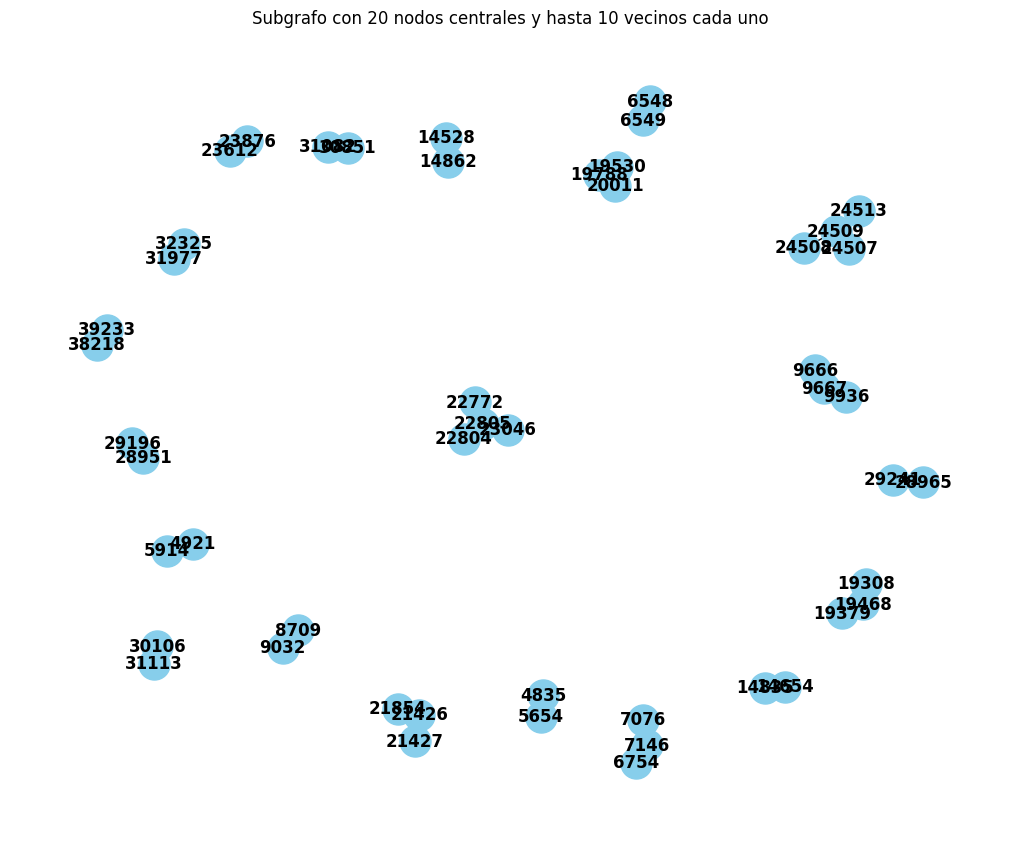

In [14]:
G = nx.Graph()

edge_index_np = data.edge_index.numpy()
for i in range(edge_index_np.shape[1]):  # Iterar sobre las aristas
    source = edge_index_np[0, i]
    target = edge_index_np[1, i]
    G.add_edge(source, target)

features_np = data.x.numpy()

for node in G.nodes():
    G.nodes[node]['features'] = features_np[node]

num_central_nodes = 20  # Número de nodos centrales
central_nodes = np.random.choice(list(G.nodes()), size=num_central_nodes, replace=False)

# Inicializa un conjunto para todos los nodos que serán incluidos en el subgrafo
all_nodes = set(central_nodes)

# Número de vecinos a incluir para cada nodo central
num_neighbors = 10

# Encuentra los vecinos de cada nodo central y los añade al conjunto
for node in central_nodes:
    neighbors = list(G.neighbors(node))[:num_neighbors]
    all_nodes.update(neighbors)

# Crea el subgrafo con los nodos seleccionados
subG = G.subgraph(all_nodes)

# Visualiza el subgrafo
plt.figure(figsize=(10, 8))
nx.draw(subG, with_labels=True, node_color='skyblue', node_size=500, edge_color='k', font_weight='bold')
plt.title(f"Subgrafo con {num_central_nodes} nodos centrales y hasta {num_neighbors} vecinos cada uno")
plt.show()

In [15]:
nodos = list(G.nodes())
print(nodos[:20])

[86, 0, 171, 841, 1934, 963, 355, 988, 808, 939, 2097, 750, 53, 377, 1191, 900, 1641, 1779, 1395, 523]


### Model

In [16]:
"""class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Primera capa convolucional
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Segunda capa convolucional
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)""" 

'class GCN(nn.Module):\n    def __init__(self, num_features, num_classes):\n        super(GCN, self).__init__()\n        self.conv1 = GCNConv(num_features, 16)\n        self.conv2 = GCNConv(16, num_classes)\n\n    def forward(self, data):\n        x, edge_index = data.x, data.edge_index\n\n        # Primera capa convolucional\n        x = self.conv1(x, edge_index)\n        x = F.relu(x)\n        x = F.dropout(x, training=self.training)\n\n        # Segunda capa convolucional\n        x = self.conv2(x, edge_index)\n\n        return F.log_softmax(x, dim=1)'

In [17]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [18]:
num_nodes = data.num_nodes
indices = torch.randperm(num_nodes)
train_mask = indices[:int(num_nodes * 0.8)]  # 80% para entrenamiento
test_mask = indices[int(num_nodes * 0.8):]  # 20% para prueba

# Inicialización del modelo, optimizador y criterio de pérdida
#model = GCN(num_features=data.num_features, num_classes=2)  # Asume 2 clases
model = GAT(num_features=data.num_features, num_classes=2)  # Asume 2 clases

optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

In [19]:
def train_epoch(data, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=1)
    correct = (pred[train_mask] == data.y[train_mask]).sum().item()
    total = train_mask.sum().item()
    return loss.item(), correct / total

def evaluate(data, test_mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred[test_mask] == data.y[test_mask]).sum().item()
        total = test_mask.sum().item()
        accuracy = correct / total
    return accuracy


In [20]:
for epoch in range(2000):
    loss, acc = train_epoch(data, train_mask)
    print(f'Epoch {epoch}, Loss: {loss}, Acc: {acc}')

test_acc = evaluate(data, test_mask)
print(f'Test Accuracy: {test_acc}')


Epoch 0, Loss: 5.8196282386779785, Acc: 2.649798861326108e-05
Epoch 1, Loss: 4.318058013916016, Acc: 3.039217325362193e-05
Epoch 2, Loss: 2.4217021465301514, Acc: 3.34120119350392e-05
Epoch 3, Loss: 2.1960182189941406, Acc: 3.470161454994542e-05
Epoch 4, Loss: 1.6659607887268066, Acc: 3.5868947149484876e-05
Epoch 5, Loss: 1.588284969329834, Acc: 3.633380390602084e-05
Epoch 6, Loss: 1.4774984121322632, Acc: 3.696822379707489e-05
Epoch 7, Loss: 1.419655203819275, Acc: 3.720930335567543e-05
Epoch 8, Loss: 1.3646615743637085, Acc: 3.719776844856535e-05
Epoch 9, Loss: 1.3334208726882935, Acc: 3.7513824903381366e-05
Epoch 10, Loss: 1.2884330749511719, Acc: 3.758764830888584e-05
Epoch 11, Loss: 1.1852779388427734, Acc: 3.761533208595002e-05
Epoch 12, Loss: 1.1688480377197266, Acc: 3.772145323136269e-05
Epoch 13, Loss: 1.0259500741958618, Acc: 3.7873714005215664e-05
Epoch 14, Loss: 0.9346337914466858, Acc: 3.7741062573449816e-05
Epoch 15, Loss: 0.8667929172515869, Acc: 3.785525815383955e-05
Ep

KeyboardInterrupt: 

In [ ]:

"""
# Suponiendo que 'data' es tu único objeto Data, pero puedes tener varios en un DataLoader si es necesario
loader = DataLoader([data], batch_size=32, shuffle=True)

model = GCN(num_features=data.num_features, num_classes=2)  # Asumiendo 2 clases: lícito e ilícito
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        return loss

for epoch in range(200):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss.item()}')
"""

"\n# Suponiendo que 'data' es tu único objeto Data, pero puedes tener varios en un DataLoader si es necesario\nloader = DataLoader([data], batch_size=32, shuffle=True)\n\nmodel = GCN(num_features=data.num_features, num_classes=2)  # Asumiendo 2 clases: lícito e ilícito\noptimizer = torch.optim.Adam(model.parameters(), lr=0.01)\ncriterion = nn.CrossEntropyLoss()\n\ndef train():\n    model.train()\n    for data in loader:\n        optimizer.zero_grad()\n        out = model(data)\n        loss = criterion(out, data.y)\n        loss.backward()\n        optimizer.step()\n        return loss\n\nfor epoch in range(200):\n    loss = train()\n    print(f'Epoch {epoch}, Loss: {loss.item()}')\n"